## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import pickle
from sklearn.metrics import ndcg_score, dcg_score

In [2]:
path_prefix = ".\\dataset1\\"

In [3]:
df_names = pd.read_table(path_prefix+'id_information_mmsr.tsv')
df_names.head(2)
len(df_names)

10095

In [4]:
song1 = df_names[df_names['id'] == 'ziT77Si01mOb5oZg']
song1

,id,artist,song,album_name
10051,ziT77Si01mOb5oZg,Frank Sinatra,Jingle Bells,Ultimate Christmas


In [9]:
song1_id = song1['id'].values[0]

# Exercise 2

In [10]:
## read all dataframes in when needed
path_prefix = ".\\dataset1\\"
df_names = pd.read_table(path_prefix+'id_information_mmsr.tsv')

feature = 'lyrics_tf-idf'
df_lyrics_tf_idf = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")
feature = 'lyrics_bert'
df_lyrics_bert = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")
feature = 'lyrics_word2vec'
df_lyrics_word2vec = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")
path_prefix = ".\\dataset2\\"
feature = 'mfcc_bow'
df_mfcc_bow = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")
feature = 'blf_spectralcontrast'
df_blf_spectralcontrast = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")
feature = 'ivec256'
df_ivec256 = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")
feature = 'musicnn'
df_musicnn = pd.read_table(path_prefix+f"id_{feature}_mmsr.tsv")

# TODO: Normalize features to improve performance

In [11]:

def read_df(feature:str):
    if feature.startswith('lyrics'):
        if feature == 'lyrics_tf-idf':
            return df_lyrics_tf_idf
        elif feature == 'lyrics_bert':
            return df_lyrics_bert            
        elif feature == 'lyrics_word2vec':
            return df_lyrics_word2vec
        else:
            raise('feature not found')
    else:
        if feature == 'mfcc_bow':
            return df_mfcc_bow
        elif feature == 'blf_spectralcontrast':
            return df_blf_spectralcontrast            
        elif feature == 'ivec256':
            return df_ivec256
        elif feature == 'musicnn':
            return df_musicnn
 
        else:
            raise('feature not found')
    return


## Exercise 2\Task 2: Evaluation
**Accuracy:**
* Precision@k & Recall@k: according to the definition given in the lecture. Consider top k retrieved items. For the purposes of precision and recall calculation, a retrieved track is relevant to the query track if the two tracks have at least one genre in common. Allow for evaluation with different lengths of the returned lists (i.e., consider k as a parameter in the evaluation). Compute the average of Precision@k and of Recall@k over all possible query tracks. Plot Precision-Recall curve for each of the 8 evaluated systems by varying k in the interval [1, 100].

    * **Precision = TP / (TP + FP)**
    * **Recall = TP / (TP + FN)**

In [12]:
import ast
from functools import reduce

df_genres = pd.read_table(path_prefix+f"id_genres_mmsr.tsv")
df_genres['genre_set'] = df_genres['genre'].apply(lambda x : set(ast.literal_eval(x))) # transform string to list and then to set, because later on set comparition will be performed
genres =  reduce(lambda x, y: x.union(y),df_genres['genre_set'], set()) # all unique genre values
enumerated_genres = {label: i for i, label in enumerate(genres, 1)} # enumerate genres
df_genres['genre'] = df_genres['genre_set'].apply(lambda x : set(enumerated_genres[g] for g in x) ) # replace genres with number encoding
df_genres.head(1)

,id,genre,genre_set
0,01Yfj2T3YTwJ1Yfy,"{643, 791}","{christian rock, rock}"


In [13]:
def get_genre(song_id):
    return df_genres.loc[df_genres['id'] == song_id]['genre'].values[0]
genre = get_genre(song1_id)
genre


{31, 370, 568, 657, 764}

In [14]:
## for accuracy recall, precision
def enrich_resultset(resultset, target_genres, dataset):
    dataset = pd.merge(dataset,resultset['id'] , how='left', on='id', indicator='positive') # left join recommended songs to all songs. Therefore, the top k songs are (true or false) positive 
    dataset['positive'] = np.where(dataset.positive == 'both', True, False) # top k songs are most similar = recommender system recoginised as positive.
    mask = dataset['genre'].apply(lambda x:  True if x & target_genres else False ) # two tracks have at least one genre in common: to calculate if the similarity was right -> true or false postives.
    dataset['true'] = mask
    return dataset
## for accuracy recall, precision
def confusion_matrix(resultset):
    tp = ( resultset['positive'] & resultset['true'] ).values.sum()
    fp = ( resultset['positive']  & ~( resultset['true'] )).values.sum() 
    fn = (~( resultset['positive'] ) & ( resultset['true'] )).values.sum()
    tn = (~( resultset['positive']) & ~( resultset['true'] )).values.sum() 
    # print(f"k: {len() }, tp: {tp} fp: {fp} fn: {fn} tn: {tn}")
    precision = tp/(tp+fp) # TP / (TP + FP)
    recall = tp/(tp+fn) # TP / (TP + FN) 
    return recall.round(3), precision.round(3)

## for accuracy nDCG
def enrich_gain(resultset, target_genres, dataset):
    dataset = pd.merge(dataset,resultset['id'] , how='inner', on='id', indicator='positive') # left join recommended songs to all songs. Therefore, the top k songs are (true or false) positive 
    #dataset['positive'] = np.where(dataset.positive == 'both', True, False) # top k songs are most similar = recommender system recoginised as positive.
    #mask = dataset['genre'].apply(lambda x:  True if x & target_genres else False ) # two tracks have at least one genre in common: to calculate if the similarity was right -> true or false postives.
    #dataset['true'] = mask
    mask = dataset['genre'].apply(lambda x: 2* len( x & target_genres ) / len( x | target_genres ) )
    dataset['rel'] = mask
    return dataset
## for accuracy nDCG
def nDCG(df):
    relevance_score = np.asarray([df['rel']]) # Relevance scores in output order
    true_relevance = np.asarray([df.sort_values(by="rel", ascending=False )['rel']]) # Relevance scores in Ideal order
    #print(relevance_score)
    #print(true_relevance)
    dcg = dcg_score(true_relevance, relevance_score)
    idcg = dcg_score(true_relevance, true_relevance)
    # print(f"DCG score : {dcg}, IDCG score : {idcg})")   # , nDCG : {ndcg}" )
    
    # ndcg = dcg / idcg # Normalized DCG score .. throws error because of ZeroDivisionError
    ndcg = idcg and dcg / idcg or 0  # Normalized DCG score ..  dcg / idcg .. efficient handling of ZeroDivisionError
    return ndcg


In [15]:
## TEST
#df = None
#feature = 'musicnn'
## if song_id:
##     song_list_of_genres = df_genres.loc[df_genres['id'] == song_id].copy()
## else:
#song_list_of_genres = df_genres.copy() # TEST! # df_genres.copy() # test! df_genres[0:2]
#for index, song in song_list_of_genres.head(2).iterrows():
#    df = read_df(feature)
#    df = df.loc[(df['id'] != song['id'])].copy()
#    df = df.loc[(df['id'] != song['id'])].copy() # this dataset without target song
#    df['similarity'] = cosine_similarity(df.iloc[:, 1:], song_vec.iloc[:, 1:]) #similarity between songs from dataset and target song
#    df = df.sort_values(by='similarity', ascending=False).head(k)[['id', 'similarity']] #take k the greatest similarity values, we need id and similarity value        
#    df = enrich_resultset(df, song['genre'], df_genres) # df = recommended songs
#    recall, precision = confusion_matrix(df) # calculate accuracy by precision, recall
#    precision_list[index] = precision
#    recall_list[index] = recall
#    if index%100 == 0 :
#        print(f"{similarity}({feature})@{k}: song idx {index}, precision: {precision}, recall: {recall} ") 

In [16]:
#df = None
#feature = 'musicnn'
#k = 10
#
#from sklearn.metrics import ndcg_score, dcg_score
## if song_id:
##     song_list_of_genres = df_genres.loc[df_genres['id'] == song_id].copy()
## else:
#song_list_of_genres = df_genres[:1].copy() # TEST! # df_genres.copy() # test! df_genres[0:2]
#ndcg_list = [0]*len(song_list_of_genres)
#for index, song in song_list_of_genres.iterrows():
#    df = read_df(feature)
#    print(f"idx: {index} genres {song['genre']}")
#    song_vec = df.loc[(df['id'] == song['id'])].copy()
#    df = df.loc[(df['id'] != song['id'])].copy() # this dataset without target song
#    df['similarity'] = cosine_similarity(df.iloc[:, 1:], song_vec.iloc[:, 1:]) #similarity between songs from dataset and target song
#    df = df.sort_values(by='similarity', ascending=False).head(k)[['id', 'similarity']] #take k the greatest similarity values, we need id and similarity value        
#    df = enrich_gain(df, song['genre'], df_genres) # df = recommended songs
#    ndcg_list[index] = nDCG(df)
#print(ndcg_list)
#df

In [17]:
def ndcg_curve(feature:str, similarity:str, k:int=10, song_id:str = None):
    song_list_of_genres = []
    
    df_feature = None

    song_list_of_genres = df_genres.copy() # TEST! # df_genres.copy() # test! df_genres[0:2]
    if feature != '-':
        df_feature = read_df(feature)
    else:
        df_feature = df_names
    size_list = len(df_feature)
    
    if similarity == 'cosine_similarity': 
        ndcg_list = [0]*len(song_list_of_genres)
        
        for index, song in song_list_of_genres.iterrows():
            song_vec = df_feature.loc[df_feature['id'] == song['id']].copy() # target song vector, make copy because we need to manipulate the feature vector separately
            # print(f'index : {index}')
            df = df_feature.loc[(df_feature['id'] != song['id'])].copy() # this dataset without target song
            df['similarity'] = cosine_similarity(df.iloc[:, 1:], song_vec.iloc[:, 1:]) #similarity between songs from dataset and target song
            df = df.sort_values(by='similarity', ascending=False).head(k)[['id', 'similarity']] #take k the greatest similarity values, we need id and similarity value        
            df = enrich_gain(df, song['genre'], df_genres) # df = recommended songs
            ndcg = nDCG(df) # calculate accuracy by ndcg
            ndcg_list[index] = ndcg    
            if index%100 == 0 :
                print(f"{similarity}({feature})@{k}: song idx {index}, ndcg: {ndcg}")            
        
        # numpy.average
        avg_ndcg = np.average(ndcg_list)
        return  avg_ndcg

    elif similarity == 'euclidean_distances':   
        ndcg_list = [0]*len(song_list_of_genres)
        
        for index, song in song_list_of_genres.iterrows():
            song_vec = df_feature.loc[df_feature['id'] == song['id']].copy() # target song vector, make copy because we need to manipulate the feature vector separately
            df = df_feature.loc[(df_feature['id'] != song['id'])].copy() # this dataset without target song 
            df['similarity'] = euclidean_distances(df.iloc[:, 1:], song_vec.iloc[:, 1:]) #similarity between songs from dataset and target song
            df = df.sort_values(by='similarity', ascending=False).head(k)[['id', 'similarity']] #take k the greatest similarity values, we need id and similarity value        
            df = enrich_gain(df, song['genre'], df_genres) # df = recommended songs
            ndcg = nDCG(df) # calculate accuracy by ndcg
            ndcg_list[index] = ndcg    
            if index%100 == 0 :
                print(f"{similarity}({feature})@{k}: song idx {index}, ndcg: {ndcg}")            
        
        # numpy.average
        avg_ndcg = np.average(ndcg_list)
        return  avg_ndcg
            

    elif feature == '-' or similarity == '-':    
        ndcg_list = [0]*len(song_list_of_genres)
        
        for index, song in song_list_of_genres.iterrows():
            song_vecd = df_feature.loc[df_names['id'] == song['id']].copy() # target song vector, make copy because we need to manipulate the feature vector separately
            df = df_feature.loc[(df_names['id'] != song['id'])].sample(n=k).copy()  
            df = enrich_gain(df, song['genre'], df_genres) # df = recommended songs
            ndcg = nDCG(df) # calculate accuracy by ndcg
            ndcg_list[index] = ndcg    
            if index%100 == 0 :
                print(f"{similarity}({feature})@{k}: song idx {index}, ndcg: {ndcg}")            
        
        # numpy.average
        avg_ndcg = np.average(ndcg_list)
        return  avg_ndcg
        
    return 

In [18]:
def recall_precision_curve(feature:str, similarity:str = 'cosine_similarity', k:int=30, song_id:str = None):
    song_list_of_genres = []
    resultset_df = []
    
    df_feature = None

    # if song_id:
    #     song_list_of_genres = df_genres.loc[df_genres['id'] == song_id].copy()
    # else:
    song_list_of_genres = df_genres.copy() # TEST! # df_genres.copy() # test! df_genres[0:2]
    if feature != '-':
        df_feature = read_df(feature)
    
    size_list = len(df_feature)
    #print(size_list)
    #print(len(song_list_of_genres))
    
    if similarity == 'cosine_similarity': 
        precision_list = [0] * size_list
        recall_list = [0] * size_list
        
        for index, song in song_list_of_genres.iterrows():
            song_vec = df_feature.loc[df_feature['id'] == song['id']].copy() # target song vector, make copy because we need to manipulate the feature vector separately
            df = df_feature.loc[(df_feature['id'] != song['id'])].copy() # this dataset without target song
            df['similarity'] = cosine_similarity(df.iloc[:, 1:], song_vec.iloc[:, 1:]) #similarity between songs from dataset and target song
            df = df.sort_values(by='similarity', ascending=False).head(k)[['id', 'similarity']] #take k the greatest similarity values, we need id and similarity value        
            df = enrich_resultset(df, song['genre'], df_genres) # df = recommended songs
            recall, precision = confusion_matrix(df) # calculate accuracy by precision, recall
            precision_list[index] = precision
            recall_list[index] = recall
            #if index%100 == 0 :
            #    print(f"{similarity}({feature})@{k}: song idx {index}, precision: {precision}, recall: {recall} ")            
        
        # numpy.average
        avg_recall = np.average(recall_list)
        avg_precision = np.average(precision_list)
        return  avg_recall, avg_precision

    elif similarity == 'euclidean_distances':   
        precision_list = [0] * size_list
        recall_list = [0] * size_list
        for index, song in song_list_of_genres.iterrows():
            song_vec = df_feature.loc[df_feature['id'] == song['id']].copy() # target song vector, make copy because we need to manipulate the feature vector separately
            df = df_feature.loc[(df_feature['id'] != song['id'])].copy() # this dataset without target song 
            df['similarity'] = euclidean_distances(df.iloc[:, 1:], song_vec.iloc[:, 1:]) #similarity between songs from dataset and target song
            df = df.sort_values(by='similarity', ascending=False).head(k)[['id', 'similarity']] #take k the greatest similarity values, we need id and similarity value        
            df = enrich_resultset(df, song['genre'], df_genres) # df = recommended songs
            recall, precision = confusion_matrix(df) # calculate accuracy by precision, recall
            precision_list[index] = precision
            recall_list[index] = recall
            #if index%100 == 0 :
            #    print(f"{similarity}({feature})@{k}: song idx {index}, precision: {precision}, recall: {recall} ")            
        
        # numpy.average
        avg_recall = np.average(recall_list)
        avg_precision = np.average(precision_list)
        return  avg_recall, avg_precision
            

    elif feature == '-' or similarity == '-':    
        precision_list = [0] * size_list
        recall_list = [0] * size_list        
        for index, song in song_list_of_genres.iterrows():
            song_vecd = f_feature.loc[df_feature['id'] == song['id']].copy() # target song vector, make copy because we need to manipulate the feature vector separately
            df = df_feature.loc[(df_feature['id'] != song['id'])].sample(n=k).copy()  
            df = enrich_resultset(df, song['genre'], df_genres).copy() # df = recommended songs
            recall, precision = confusion_matrix(df) # calculate accuracy by precision, recall
            precision_list[index] = precision
            recall_list[index] = recall
            #if index%100 == 0 :
            #    print(f"{similarity}({feature})@{k}: song idx {index}, precision: {precision}, recall: {recall} ")            

        # numpy.average
        avg_recall = np.average(recall_list)
        avg_precision = np.average(precision_list)
        return  avg_recall, avg_precision        
        
    return 

In [21]:
# test step of confusion matrix: 
song1_id = song1['id'].values[0]
recall, precision = recall_precision_curve(feature = 'musicnn', similarity = 'cosine_similarity', k=30) # _id
print(f"recall: {recall} precision: {precision}")

song1_id

'ziT77Si01mOb5oZg'

In [22]:
def write_to(df, filename):
    try:
        with open(filename, 'rb') as fp:
            existing_data = pickle.load(fp)
            print(existing_data)
    except FileNotFoundError:
        # If the file doesn't exist, create it with the new row
        existing_data = df.head(0)


    with open(filename, 'wb') as fp:   
        existing_data = existing_data.append(df)
        pickle.dump(existing_data, fp)
    

In [23]:
## TEST 
#filename="test_accuracy.pkl"
#
#feature='mfcc_bow'# 'musicnn'
#similarity = 'cosine_similarity'
#k=30
#
#precision_list, recall_list = recall_precision_curve(feature = feature, k = k, similarity = similarity)
#print(precision_list,recall_list)
#result_df = pd.DataFrame({"feature": [feature], "similarity": [similarity], "k": [k], "precision": [precision], "recall": [recall]}) 
#try:
#    with open(filename, 'rb') as fp:
#        existing_data = pickle.load(fp)
#        print(existing_data)
#except FileNotFoundError:
#    # If the file doesn't exist, create it with the new row
#    existing_data = result_df.head(0)
#    
#
#with open(filename, 'wb') as fp:   
#    existing_data = existing_data.append(result_df)
#    pickle.dump(existing_data, fp)
#    
#obj = pd.read_pickle(f'{filename}')  
#obj


In [24]:
#step = 10
#k_interval = [10,100+step]
#np.arange(*k_interval,10)

## Evaluation Accuracy Precision@k & Recall@k Source Code

In [25]:
recommender_systems = {  
                       'mfcc_bow': {'kind':'audio_based', 'feature': 'mfcc_bow', 'similarity': 'cosine_similarity'}
                        , 'blf_spectralcontrast': {'kind':'audio_based','feature': 'blf_spectralcontrast', 'similarity': 'cosine_similarity'}
                        , 'ivec256': {'kind':'audio_based','feature': 'ivec256', 'similarity': 'cosine_similarity'}
                        , 'musicnn': {'kind':'audio_based','feature': 'musicnn', 'similarity': 'cosine_similarity'}
                       ,  'random': {'kind':'-','feature': '-', 'similarity': '-'}
                       , 'cos(tf-idf)': {'kind':'text_based','feature': 'lyrics_tf-idf', 'similarity': 'cosine_similarity'}
                       , 'cos(bert)': {'kind':'text_based','feature': 'lyrics_bert', 'similarity': 'cosine_similarity'}
                      , 'euclidean(word2vec)': {'kind':'text_based','feature': 'lyrics_word2vec', 'similarity': 'euclidean_distances'}
                      } 

In [ ]:
filename="accuracy_ndcg.pkl"

# iterates all recommender systems and calcualtes the recall precision for k recommended songs for target song (k is within the intervall of k_interval)
def ndcg_curve_foreach_rs(song:str = None, k_interval:[int, int]=[1, 10]):
    
    precision_list = []
    recall_list = []
    for rs in recommender_systems.keys():
        feature = recommender_systems[rs]['feature'];
        similarity = recommender_systems[rs]['similarity'];
        for k in k_interval: # np.arange(*k_interval,100): # make for each k one file; # 100,100
            
            print(f"recommender system: {rs}, feature: {feature}, similarity: {similarity}, k: {k}")
            ndcg = ndcg_curve(feature = feature, similarity = similarity, k= k, song_id = None )
            
            #recall_precision_curve_result[rs] = {'precision': precision,'recall': recall }
            result_df = pd.DataFrame({"feature": [feature], "similarity": [similarity], "k": [k], "ndcg": [ndcg]}) 
            # save to file
            write_to(result_df, filename)

# calculate the precision recall over all recommender systems, with k recommended songs
step = 10
k_interval = [10]
ndcg_curve_foreach_rs(song = None, k_interval =k_interval)

In [85]:
filename="accuracy.pkl"

recall_precision_curve_result = dict({ })
song_id = song1['id'].values[0]

# iterates all recommender systems and calcualtes the recall precision for k recommended songs for target song (k is within the intervall of k_interval)
def recall_precision_curve_foreach_rs(song:str = None, k_interval:[int, int]=[1, 10]):
    
    precision_list = []
    recall_list = []
    for rs in recommender_systems.keys():
        feature = recommender_systems[rs]['feature'];
        similarity = recommender_systems[rs]['similarity'];
        for k in k_arange: # np.arange(*k_interval,100): # make for each k one file; # 100,100
            
            print(f"recommender system: {rs}, feature: {feature}, similarity: {similarity}, k: {k}")
            recall, precision = recall_precision_curve(feature = feature, similarity = similarity, k= k, song_id = None )
            
            #recall_precision_curve_result[rs] = {'precision': precision,'recall': recall }
            result_df = pd.DataFrame({"feature": [feature], "similarity": [similarity], "k": [k], "precision": [precision], "recall": [recall]}) 
            # save to file
            write_to(result_df, filename)

# calculate the precision recall over all recommender systems, with k recommended songs
step = 10
k_interval = [80,100+step]
k_arange = np.arange(*k_interval,10)
#recall_precision_curve_foreach_rs(song = None, k_interval =[1,100] )
recall_precision_curve_foreach_rs(song = None, k_interval =k_arange)

## gestartet 18:30

recommender system: mfcc_bow, feature: mfcc_bow, similarity: cosine_similarity, k: 80
                feature           similarity    k  precision    recall
0              mfcc_bow    cosine_similarity   10   0.588518  0.001707
0              mfcc_bow    cosine_similarity   20   0.583604  0.003324
0              mfcc_bow    cosine_similarity   30   0.581050  0.004946
0              mfcc_bow    cosine_similarity   40   0.578680  0.006486
0               musicnn    cosine_similarity   10   0.623598  0.001908
0               ivec256    cosine_similarity   10   0.565564  0.001685
0              mfcc_bow    cosine_similarity   50   0.576386  0.007995
0               musicnn    cosine_similarity   20   0.619690  0.003762
0               ivec256    cosine_similarity   20   0.556989  0.003327
0               musicnn    cosine_similarity   30   0.617877  0.005598
0               ivec256    cosine_similarity   30   0.551183  0.004817
0               musicnn    cosine_similarity   40   0.616200  

## Evaluation Results for Accuracy Precision@k & Recall@k

In [26]:
filename="accuracy.pkl"
with open(filename, 'rb') as fp:
    existing_data = pickle.load(fp)
    existing_data
df = existing_data.drop_duplicates()
df

,feature,similarity,k,precision,recall
0,mfcc_bow,cosine_similarity,10,0.588518,0.001707
0,mfcc_bow,cosine_similarity,20,0.583604,0.003324
0,mfcc_bow,cosine_similarity,30,0.581050,0.004946
0,mfcc_bow,cosine_similarity,40,0.578680,0.006486
0,musicnn,cosine_similarity,10,0.623598,0.001908
...,...,...,...,...,...
0,lyrics_bert,cosine_similarity,100,0.536913,0.015934
0,lyrics_tf-idf,cosine_similarity,70,0.499425,0.008906
0,lyrics_tf-idf,cosine_similarity,80,0.498395,0.010136
0,lyrics_tf-idf,cosine_similarity,90,0.497521,0.011347


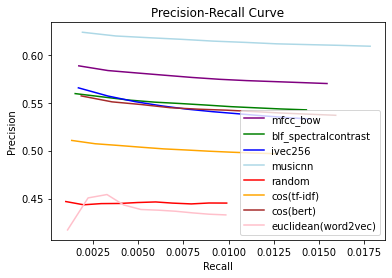

In [27]:
import matplotlib.pyplot as plt

color_encoding = ['purple', 'green','blue','lightblue', 'red', 'orange', 'brown', 'pink']
fig, ax = plt.subplots()

for i, k in  enumerate(recommender_systems.keys()):
    feature = recommender_systems[k]['feature']
    similarity = recommender_systems[k]['similarity']
    rs_df = df.loc[(df['similarity'] == similarity)& (df['feature'] == feature)].sort_values(by='k', ascending=False)
    precision_list = rs_df['precision']
    recall_list = rs_df['recall'] 
    ax.plot(recall_list, precision_list, color = color_encoding[i] )

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
# display plot
plt.legend(recommender_systems , loc ="lower right") # 'upper left'

## Evaluation Results for Accuracy nDCG@10

In [28]:

filename="accuracy_ndcg.pkl"
with open(filename, 'rb') as fp:
    existing_data = pickle.load(fp)
    existing_data
df = existing_data.drop_duplicates()
print(df)

                feature           similarity   k      ndcg
0              mfcc_bow    cosine_similarity  10  0.645689
0  blf_spectralcontrast    cosine_similarity  10  0.633859
0               ivec256    cosine_similarity  10  0.639641
0               musicnn    cosine_similarity  10  0.667799
0                     -                    -  10  0.574037
0         lyrics_tf-idf    cosine_similarity  10  0.611410
0           lyrics_bert    cosine_similarity  10  0.632236
0       lyrics_word2vec  euclidean_distances  10  0.574485


In [29]:
# df = existing_data.drop_duplicates()
# df = df.loc[~((df['k']== 30) & (df['precision'] == 0.267000)) ]
# 
# filename="accuracy_new.pkl"
# 
# result_df = df
# try:
#     with open(filename, 'rb') as fp:
#         existing_data = pickle.load(fp)
#         print(existing_data)
# except FileNotFoundError:
#     # If the file doesn't exist, create it with the new row
#     existing_data = result_df.head(0)
#     
# 
# with open(filename, 'wb') as fp:   
#     existing_data = existing_data.append(result_df)
#     pickle.dump(existing_data, fp)
#     
# obj = pd.read_pickle(f'{filename}')  
# obj